# MOGDx 

In [3]:
import argparse
import pandas as pd
import numpy as np
import os
import sys  
sys.path.insert(0, './MAIN/')
from utils import *
from GNN_MME import *
from train import *
import preprocess_functions

import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold , train_test_split
import networkx as nx
import torch
from datetime import datetime
import joblib
import warnings
import gc
warnings.filterwarnings("ignore")

print("Finished Library Import \n")

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Finished Library Import 



In [4]:
data_input = './../data/raw/'
snf_net = 'Clinical_RPPA_mRNA_graph.graphml'
index_col = 'index'
target = 'paper_BRCA_Subtype_PAM50'

Using cuda device
Total = 6.4Gb 	 Reserved = 0.0Gb 	 Allocated = 0.0Gb
StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
GCN_MME(
  (encoder_dims): ModuleList(
    (0): Encoder(
      (encoder): ModuleList(
        (0): Linear(in_features=2048, out_features=500, bias=True)
        (1): Linear(in_features=500, out_features=16, bias=True)
      )
      (norm): ModuleList(
        (0): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (decoder): Sequential(
        (0): Linear(in_features=16, out_features=64, bias=True)
      )
      (drop): Dropout(p=0.5, inplace=False)
    )
    (1): Encoder(
      (encoder): ModuleList(
        (0): Linear(in_features=464, out_features=500, bias=True)
        (1): Linear(in_features=500, out_features=16, bias=True)
      )
      (norm): ModuleList(
        (0): BatchNorm1d(500, eps=1e-05, momentum=0.1, aff

Epoch 00405 | Loss 0.3844 | Train Acc. 0.8512 | Validation Acc. 0.8218 
Epoch 00410 | Loss 0.4209 | Train Acc. 0.8497 | Validation Acc. 0.8046 
Epoch 00415 | Loss 0.3849 | Train Acc. 0.8598 | Validation Acc. 0.8103 
Epoch 00420 | Loss 0.4123 | Train Acc. 0.8584 | Validation Acc. 0.8276 
Epoch 00425 | Loss 0.3853 | Train Acc. 0.8671 | Validation Acc. 0.8276 
Epoch 00430 | Loss 0.4131 | Train Acc. 0.8425 | Validation Acc. 0.8103 
Epoch 00435 | Loss 0.3916 | Train Acc. 0.8540 | Validation Acc. 0.8046 
Epoch 00440 | Loss 0.4014 | Train Acc. 0.8656 | Validation Acc. 0.7816 
Epoch 00445 | Loss 0.4271 | Train Acc. 0.8526 | Validation Acc. 0.8161 
Epoch 00450 | Loss 0.4308 | Train Acc. 0.8512 | Validation Acc. 0.8103 
Epoch 00455 | Loss 0.4377 | Train Acc. 0.8555 | Validation Acc. 0.8333 
Epoch 00460 | Loss 0.3976 | Train Acc. 0.8642 | Validation Acc. 0.8046 
Epoch 00465 | Loss 0.4256 | Train Acc. 0.8540 | Validation Acc. 0.8161 
Epoch 00470 | Loss 0.4154 | Train Acc. 0.8410 | Validation Acc. 

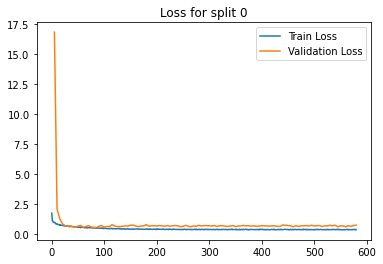

Fold : 1 | Test Accuracy = 0.7788 | F1 = 0.7527 
Total = 6.4Gb 	 Reserved = 0.9Gb 	 Allocated = 0.3Gb
Clearing gpu memory
Total = 6.4Gb 	 Reserved = 0.3Gb 	 Allocated = 0.3Gb
GCN_MME(
  (encoder_dims): ModuleList(
    (0): Encoder(
      (encoder): ModuleList(
        (0): Linear(in_features=2048, out_features=500, bias=True)
        (1): Linear(in_features=500, out_features=16, bias=True)
      )
      (norm): ModuleList(
        (0): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (decoder): Sequential(
        (0): Linear(in_features=16, out_features=64, bias=True)
      )
      (drop): Dropout(p=0.5, inplace=False)
    )
    (1): Encoder(
      (encoder): ModuleList(
        (0): Linear(in_features=464, out_features=500, bias=True)
        (1): Linear(in_features=500, out_features=16, bias=True)
      )
      (norm): ModuleList(
        (0): Ba

Epoch 00400 | Loss 0.4395 | Train Acc. 0.8685 | Validation Acc. 0.8046 
Epoch 00405 | Loss 0.4276 | Train Acc. 0.8584 | Validation Acc. 0.7989 
Epoch 00410 | Loss 0.4585 | Train Acc. 0.8642 | Validation Acc. 0.7931 
Epoch 00415 | Loss 0.4535 | Train Acc. 0.8512 | Validation Acc. 0.7931 
Epoch 00420 | Loss 0.4271 | Train Acc. 0.8367 | Validation Acc. 0.7989 
Epoch 00425 | Loss 0.4679 | Train Acc. 0.8439 | Validation Acc. 0.7931 
Epoch 00430 | Loss 0.4292 | Train Acc. 0.8598 | Validation Acc. 0.8046 
Epoch 00435 | Loss 0.4404 | Train Acc. 0.8584 | Validation Acc. 0.7989 
Epoch 00440 | Loss 0.4518 | Train Acc. 0.8512 | Validation Acc. 0.8103 
Epoch 00445 | Loss 0.4327 | Train Acc. 0.8613 | Validation Acc. 0.7701 
Epoch 00450 | Loss 0.4226 | Train Acc. 0.8512 | Validation Acc. 0.8046 
Epoch 00455 | Loss 0.4492 | Train Acc. 0.8497 | Validation Acc. 0.7931 
Epoch 00460 | Loss 0.4258 | Train Acc. 0.8627 | Validation Acc. 0.7989 
Epoch 00465 | Loss 0.4536 | Train Acc. 0.8396 | Validation Acc. 

<Figure size 432x288 with 0 Axes>

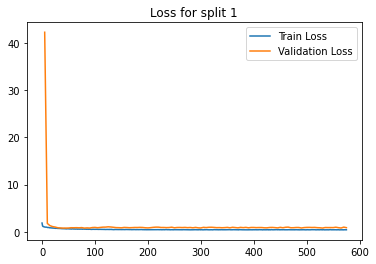

Fold : 2 | Test Accuracy = 0.8249 | F1 = 0.7929 
Total = 6.4Gb 	 Reserved = 1.1Gb 	 Allocated = 0.3Gb
Clearing gpu memory
Total = 6.4Gb 	 Reserved = 0.4Gb 	 Allocated = 0.3Gb
GCN_MME(
  (encoder_dims): ModuleList(
    (0): Encoder(
      (encoder): ModuleList(
        (0): Linear(in_features=2048, out_features=500, bias=True)
        (1): Linear(in_features=500, out_features=16, bias=True)
      )
      (norm): ModuleList(
        (0): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (decoder): Sequential(
        (0): Linear(in_features=16, out_features=64, bias=True)
      )
      (drop): Dropout(p=0.5, inplace=False)
    )
    (1): Encoder(
      (encoder): ModuleList(
        (0): Linear(in_features=464, out_features=500, bias=True)
        (1): Linear(in_features=500, out_features=16, bias=True)
      )
      (norm): ModuleList(
        (0): Ba

Epoch 00400 | Loss 0.4301 | Train Acc. 0.8425 | Validation Acc. 0.8046 
Epoch 00405 | Loss 0.4327 | Train Acc. 0.8468 | Validation Acc. 0.7874 
Epoch 00410 | Loss 0.4571 | Train Acc. 0.8353 | Validation Acc. 0.8161 
Epoch 00415 | Loss 0.4303 | Train Acc. 0.8382 | Validation Acc. 0.8046 
Epoch 00420 | Loss 0.4250 | Train Acc. 0.8396 | Validation Acc. 0.8218 
Epoch 00425 | Loss 0.4481 | Train Acc. 0.8439 | Validation Acc. 0.8218 
Epoch 00430 | Loss 0.4399 | Train Acc. 0.8439 | Validation Acc. 0.8218 
Epoch 00435 | Loss 0.4204 | Train Acc. 0.8468 | Validation Acc. 0.8161 
Epoch 00440 | Loss 0.4467 | Train Acc. 0.8324 | Validation Acc. 0.8218 
Epoch 00445 | Loss 0.4455 | Train Acc. 0.8237 | Validation Acc. 0.8046 
Epoch 00450 | Loss 0.4417 | Train Acc. 0.8338 | Validation Acc. 0.7931 
Epoch 00455 | Loss 0.4421 | Train Acc. 0.8454 | Validation Acc. 0.8046 
Epoch 00460 | Loss 0.4358 | Train Acc. 0.8338 | Validation Acc. 0.7931 
Epoch 00465 | Loss 0.4472 | Train Acc. 0.8425 | Validation Acc. 

<Figure size 432x288 with 0 Axes>

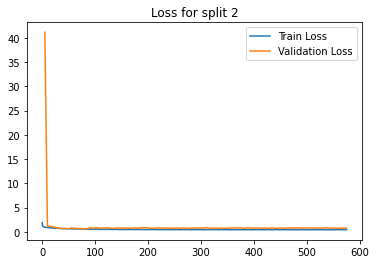

Fold : 3 | Test Accuracy = 0.8065 | F1 = 0.7649 
Total = 6.4Gb 	 Reserved = 1.1Gb 	 Allocated = 0.4Gb
Clearing gpu memory
Total = 6.4Gb 	 Reserved = 0.4Gb 	 Allocated = 0.3Gb
GCN_MME(
  (encoder_dims): ModuleList(
    (0): Encoder(
      (encoder): ModuleList(
        (0): Linear(in_features=2048, out_features=500, bias=True)
        (1): Linear(in_features=500, out_features=16, bias=True)
      )
      (norm): ModuleList(
        (0): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (decoder): Sequential(
        (0): Linear(in_features=16, out_features=64, bias=True)
      )
      (drop): Dropout(p=0.5, inplace=False)
    )
    (1): Encoder(
      (encoder): ModuleList(
        (0): Linear(in_features=464, out_features=500, bias=True)
        (1): Linear(in_features=500, out_features=16, bias=True)
      )
      (norm): ModuleList(
        (0): Ba

Epoch 00400 | Loss 0.4506 | Train Acc. 0.8427 | Validation Acc. 0.7816 
Epoch 00405 | Loss 0.4311 | Train Acc. 0.8485 | Validation Acc. 0.7816 
Epoch 00410 | Loss 0.4217 | Train Acc. 0.8456 | Validation Acc. 0.7874 
Epoch 00415 | Loss 0.4334 | Train Acc. 0.8427 | Validation Acc. 0.7816 
Epoch 00420 | Loss 0.4254 | Train Acc. 0.8571 | Validation Acc. 0.7644 
Epoch 00425 | Loss 0.4255 | Train Acc. 0.8456 | Validation Acc. 0.7874 
Epoch 00430 | Loss 0.4428 | Train Acc. 0.8571 | Validation Acc. 0.7816 
Epoch 00435 | Loss 0.4478 | Train Acc. 0.8384 | Validation Acc. 0.7644 
Epoch 00440 | Loss 0.4485 | Train Acc. 0.8485 | Validation Acc. 0.7816 
Epoch 00445 | Loss 0.4362 | Train Acc. 0.8629 | Validation Acc. 0.7931 
Epoch 00450 | Loss 0.4318 | Train Acc. 0.8658 | Validation Acc. 0.7759 
Epoch 00455 | Loss 0.4405 | Train Acc. 0.8384 | Validation Acc. 0.7759 
Epoch 00460 | Loss 0.4631 | Train Acc. 0.8528 | Validation Acc. 0.7931 
Epoch 00465 | Loss 0.4461 | Train Acc. 0.8557 | Validation Acc. 

<Figure size 432x288 with 0 Axes>

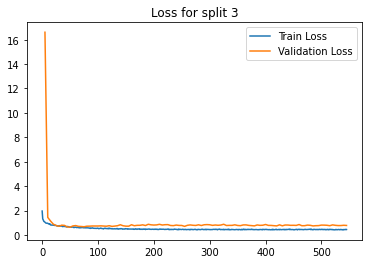

Fold : 4 | Test Accuracy = 0.8148 | F1 = 0.7905 
Total = 6.4Gb 	 Reserved = 1.1Gb 	 Allocated = 0.4Gb
Clearing gpu memory
Total = 6.4Gb 	 Reserved = 0.4Gb 	 Allocated = 0.3Gb
GCN_MME(
  (encoder_dims): ModuleList(
    (0): Encoder(
      (encoder): ModuleList(
        (0): Linear(in_features=2048, out_features=500, bias=True)
        (1): Linear(in_features=500, out_features=16, bias=True)
      )
      (norm): ModuleList(
        (0): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (decoder): Sequential(
        (0): Linear(in_features=16, out_features=64, bias=True)
      )
      (drop): Dropout(p=0.5, inplace=False)
    )
    (1): Encoder(
      (encoder): ModuleList(
        (0): Linear(in_features=464, out_features=500, bias=True)
        (1): Linear(in_features=500, out_features=16, bias=True)
      )
      (norm): ModuleList(
        (0): Ba

Epoch 00400 | Loss 0.4058 | Train Acc. 0.8615 | Validation Acc. 0.7759 
Epoch 00405 | Loss 0.4380 | Train Acc. 0.8485 | Validation Acc. 0.7644 
Epoch 00410 | Loss 0.3961 | Train Acc. 0.8716 | Validation Acc. 0.7816 
Epoch 00415 | Loss 0.4106 | Train Acc. 0.8802 | Validation Acc. 0.7759 
Epoch 00420 | Loss 0.4161 | Train Acc. 0.8615 | Validation Acc. 0.7931 
Epoch 00425 | Loss 0.4115 | Train Acc. 0.8687 | Validation Acc. 0.7644 
Epoch 00430 | Loss 0.4155 | Train Acc. 0.8586 | Validation Acc. 0.7816 
Epoch 00435 | Loss 0.4211 | Train Acc. 0.8586 | Validation Acc. 0.7644 
Epoch 00440 | Loss 0.4064 | Train Acc. 0.8716 | Validation Acc. 0.7701 
Epoch 00445 | Loss 0.3965 | Train Acc. 0.8600 | Validation Acc. 0.7644 
Epoch 00450 | Loss 0.4234 | Train Acc. 0.8644 | Validation Acc. 0.7701 
Epoch 00455 | Loss 0.4084 | Train Acc. 0.8600 | Validation Acc. 0.7701 
Epoch 00460 | Loss 0.4119 | Train Acc. 0.8600 | Validation Acc. 0.7759 
Epoch 00465 | Loss 0.4390 | Train Acc. 0.8586 | Validation Acc. 

<Figure size 432x288 with 0 Axes>

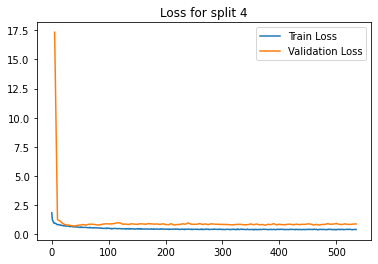

Fold : 5 | Test Accuracy = 0.7963 | F1 = 0.7672 
Total = 6.4Gb 	 Reserved = 1.1Gb 	 Allocated = 0.4Gb
Clearing gpu memory
Total = 6.4Gb 	 Reserved = 0.4Gb 	 Allocated = 0.3Gb
5 Fold Cross Validation Accuracy = 80.42 ± 1.58
5 Fold Cross Validation F1 = 77.37 ± 1.55


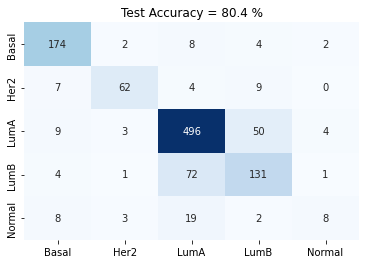

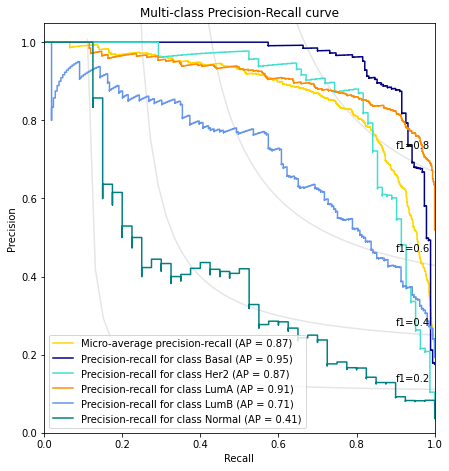

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')# Get GPU device name, else use CPU
print("Using %s device" % device)
get_gpu_memory()

datModalities , meta = data_parsing(data_input , ['Clinical', 'RPPA', 'mRNA'] , target , index_col)

graph_file = data_input + '../Networks/' + snf_net
g = nx.read_graphml(graph_file)

meta = meta.loc[sorted(meta.index)]
label = F.one_hot(torch.Tensor(list(meta.astype('category').cat.codes)).to(torch.int64))

skf = StratifiedKFold(n_splits=5 , shuffle=True) 

print(skf)

MME_input_shapes = [ datModalities[mod].shape[1] for mod in datModalities]

h = reduce(merge_dfs , list(datModalities.values()))
h = h.loc[sorted(h.index)]

g = dgl.from_networkx(g , node_attrs=['idx' , 'label'])

g.ndata['feat'] = torch.Tensor(h.to_numpy())

g.ndata['label'] = label

del datModalities
gc.collect()

output_metrics = []
test_logits = []
test_labels = []
for i, (train_index, test_index) in enumerate(skf.split(meta.index, meta)) :

    model = GCN_MME(MME_input_shapes , [16, 16 , 16] , 64 , [32], len(meta.unique())).to(device)
    
    print(model)
    print(g)

    train_index , val_index = train_test_split(
        train_index, train_size=0.8, test_size=None, stratify=meta.iloc[train_index]
        )
    
    g = g.to(device)

    loss_plot = train(g, train_index , val_index, device ,  model , label , 2000 , 1e-3 , 100)
    plt.title(f'Loss for split {i}')
    plt.show()
    plt.clf()
    
    sampler = NeighborSampler(
        [15 for i in range(len(model.gnnlayers))],  # fanout for each layer
        prefetch_node_feats=['feat'],
        prefetch_labels=['label'],
    )
    test_dataloader = DataLoader(
        g,
        torch.Tensor(test_index).to(torch.int64).to(device),
        sampler,
        device=device,
        batch_size=1024,
        shuffle=True,
        drop_last=False,
        num_workers=0,
        use_uva=False,
    )
    
    test_output_metrics = evaluate(model , g, test_dataloader)

    print(
        "Fold : {:01d} | Test Accuracy = {:.4f} | F1 = {:.4f} ".format(
        i+1 , test_output_metrics[1] , test_output_metrics[2] )
    )
    
    test_logits.extend(test_output_metrics[-2])
    test_labels.extend(test_output_metrics[-1])
    
    output_metrics.append(test_output_metrics)
    if i == 0 : 
        best_model = model
        best_idx = i
    elif output_metrics[best_idx][1] < test_output_metrics[1] : 
        best_model = model
        best_idx   = i

    get_gpu_memory()
    del model
    gc.collect()
    torch.cuda.empty_cache()
    print('Clearing gpu memory')
    get_gpu_memory()

test_logits = torch.stack(test_logits)
test_labels = torch.stack(test_labels)
    
accuracy = []
F1 = []
i = 0
for metric in output_metrics :
    
    accuracy.append(metric[1])
    F1.append(metric[2])


print("%i Fold Cross Validation Accuracy = %2.2f \u00B1 %2.2f" %(5 , np.mean(accuracy)*100 , np.std(accuracy)*100))
print("%i Fold Cross Validation F1 = %2.2f \u00B1 %2.2f" %(5 , np.mean(F1)*100 , np.std(F1)*100))

confusion_matrix(test_logits , test_labels , meta.astype('category').cat.categories)
plt.title('Test Accuracy = %2.1f %%' % (np.mean(accuracy)*100))

precision_recall_plot , all_predictions_conf = AUROC(test_logits, test_labels , meta)

node_predictions = []
node_true        = []
display_label = meta.astype('category').cat.categories
for pred , true in zip(all_predictions_conf.argmax(1) , list(test_labels.detach().cpu().argmax(1).numpy()))  : 
    node_predictions.append(display_label[pred])
    node_true.append(display_label[true])

tst = pd.DataFrame({'Actual' : node_true , 'Predicted' : node_predictions})

In [8]:
# test the model
print("Testing...")
acc = layerwise_infer(
    device, g, np.arange(len(g.nodes())), best_model, batch_size=4096
)
print("Test Accuracy {:.4f}".format(acc.item()))

Testing...


100%|██████████| 1/1 [00:00<00:00, 35.69it/s]

Test Accuracy 0.7277


100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


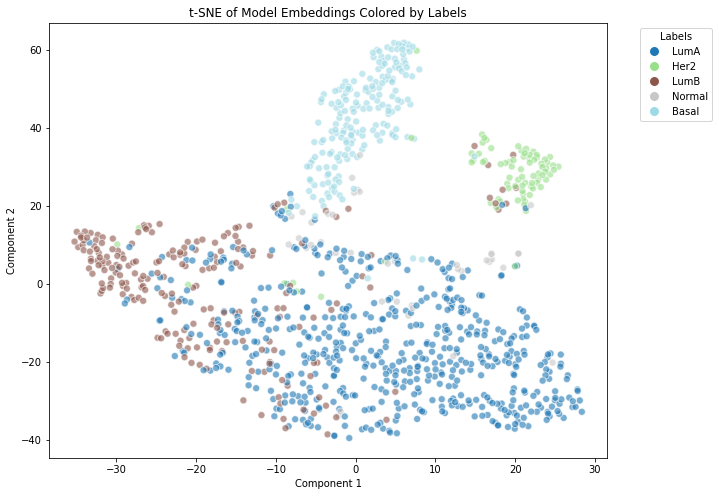

In [9]:
best_model.eval()
with torch.no_grad():
    emb = best_model.embedding_extraction(
        g, g.ndata['feat'] ,device, 4096
    )  # pred in buffer_device

tsne_embedding_plot(emb.detach().cpu().numpy() , meta)

In [10]:
pd.DataFrame(emb.detach().cpu().numpy() , index=meta.index).to_csv('./../../../MO-LLM/data/02_working/MOGDx_BRCA_embeddings.csv')